#### Importing necessary libraries

In [1]:
import copy

# Importing necessary libraries
import pandas as pd
import numpy as np
import datetime


In [2]:
# Load the dataset and preprocess
df = pd.read_csv("preprocessed_dataset.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [3]:
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:03:00,56.39,13.53,2082.27,391.733,403.738,9.70067,1.74925,250.509,251.163,250.610,...,250.389,249.430,606.023,596.422,604.776,437.700,430.352,433.920,443.036,1.40
2017-03-10 01:03:20,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,250.576,...,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,1.31
2017-03-10 01:03:40,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,250.862,...,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,1.31
2017-03-10 01:04:00,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,250.313,...,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,1.31
2017-03-10 01:04:20,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,250.049,...,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,1.31


#### Useful variables selection

In [4]:
print("TODO")

TODO


#### PLS loop

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from model import Model
from sklearn.metrics import mean_squared_error, r2_score, f1_score
import progressbar  # pip install progressbar2
import copy
import warnings
warnings.filterwarnings('ignore')

# Reduce the amount of observations (with averaging)
df = df.resample("T").mean()

included_rows1 = [df.index.get_loc(datetime.datetime(2017,4,23,19,0,0)),
                    df.index.get_loc(datetime.datetime(2017,5,13,0,59,00))]
included_rows2 = [df.index.get_loc(datetime.datetime(2017,6,15,1,0,0)),
                    df.index.get_loc(datetime.datetime(2017,7,24,0,59,00))]
included_rows3 = [df.index.get_loc(datetime.datetime(2017,8,15,1,0,0)),
                    df.index.get_loc(datetime.datetime(2017,9,10,0,0,0))]

df_array = df.to_numpy()

models = []

# Find best window_size and num_of_components
for window_size in progressbar.progressbar([10, 20, 30, 40, 50, 60, 70, 80, 90, 100]):  # [10, 20, 30, ...]
        # Division of data into training, validation and test sets for the normal functioning times:
        # about 70% for training, 15% for validation, 15% for testing
        test_size = round(0.15 * window_size)
        test_start = '2017-04-23 00:00:00' # example start of test partition
        test_start = datetime.datetime.strptime(test_start, '%Y-%m-%d %H:%M:%S')

        # Models with same window size (they all take the same windows, no need to get them multiple times...)
        models_one_win_size = [Model((window_size, i), PLSRegression(n_components=i), []) 
                               for i in range(1, df_array.shape[1] - 1)]

        flag = 0
        row_number = df.index.get_loc(test_start)
        # Iterate through the data
        while flag == 0:
            validation_data, training_data = None, None
            test_y_end = row_number+test_size + 1
            training_X_start = row_number - round(0.85 * window_size)
            # Stay within included rows
            if ((test_y_end <= included_rows1[1] and training_X_start >= included_rows1[0])
            or (test_y_end <= included_rows2[1] and training_X_start >= included_rows2[0])
            or (test_y_end <= included_rows3[1] and training_X_start >= included_rows3[0])):

                scaler = StandardScaler()

                # Validation set
                validation_X = df_array[row_number-test_size:row_number,:-1]
                validation_y = df_array[row_number-test_size+1:row_number+1,-1]

                # Training set
                training_X = df_array[training_X_start:row_number-test_size,:-1]
                training_y = df_array[training_X_start+1:row_number-test_size+1,-1]

                # TODO
                # We should scale only X, correct?
                # Compute the mean and std with training data
                scaler.fit(training_X)
                # Perform standardization
                training_X = scaler.transform(training_X)
                validation_X = scaler.transform(validation_X)

                training_y = training_y
                validation_y = validation_y

                # Lagged predictor variables and the response variable in one matrix
                validation_data = np.column_stack([validation_X, validation_y])
                training_data = np.column_stack([training_X, training_y])

                # Add the same scaler to all the models with same window size
                for model in models_one_win_size:
                    model.scalers.append(copy.deepcopy(scaler))

                if test_y_end == included_rows3[1]:
                    flag = 1
            else:
                if test_y_end > included_rows3[1]:
                    flag = 1
                    
            row_number = row_number + 1
            
            ######################    
            # Data window generated, all models here have same window size, only different num of components...
            if validation_data is None or training_data is None or np.all(validation_data[:, :-1] == 0.):
                continue

            # Iterate through all the models with same window size and fit, predict, get metrics
            for model in models_one_win_size:
                win_X = np.array(training_data[:, :-1])
                win_y = np.expand_dims(np.array(training_data[:, -1]), 1)
                
                try:
                    model.model.fit(win_X, win_y)
                except Exception as e:
                    # print(win_X, "\n", win_y, "\n", e)
                    continue
                    
                # Predict the target values
                y_train_pred = model.model.predict(win_X)
                model.train_metrics[0].append(mean_squared_error(win_y, y_train_pred))
                model.train_metrics[1].append(None)  # TODO
                model.train_metrics[2].append(r2_score(win_y, y_train_pred))
    
                win_X = validation_data[:, :-1]
                win_y = np.expand_dims(np.array(validation_data[:, -1]), 1)
                # Predict the target values
                y_valid_pred = model.model.predict(win_X)
                model.valid_metrics[0].append(mean_squared_error(win_y, y_valid_pred))
                model.valid_metrics[1].append(None)  # TODO
                model.valid_metrics[2].append(r2_score(win_y, y_valid_pred))

        models.extend(models_one_win_size)
        

  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

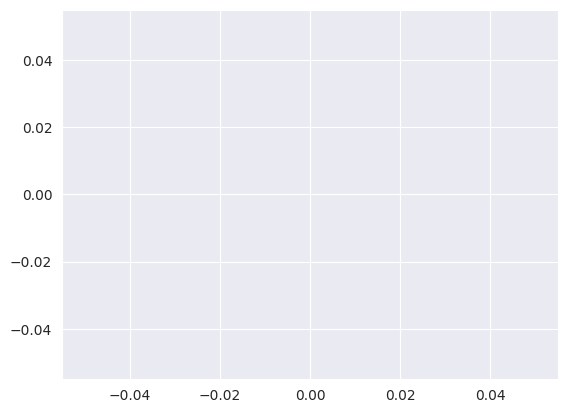

10 0 :  nan
10 1 :  nan
10 2 :  nan
10 3 :  nan
10 4 :  nan
10 5 :  nan
10 6 :  nan
10 7 :  nan
10 8 :  nan
10 9 :  nan
10 10 :  nan
10 11 :  nan
10 12 :  nan
10 13 :  nan
10 14 :  nan
10 15 :  nan
10 16 :  nan
10 17 :  nan
10 18 :  nan
10 19 :  nan
10 20 :  nan
20 0 :  nan
20 1 :  nan
20 2 :  nan
20 3 :  nan
20 4 :  nan
20 5 :  nan
20 6 :  nan
20 7 :  nan
20 8 :  nan
20 9 :  nan
20 10 :  nan
20 11 :  nan
20 12 :  nan
20 13 :  nan
20 14 :  nan
20 15 :  nan
20 16 :  nan
20 17 :  nan
20 18 :  nan
20 19 :  nan
20 20 :  nan
30 0 :  nan
30 1 :  nan
30 2 :  nan
30 3 :  nan
30 4 :  nan
30 5 :  nan
30 6 :  nan
30 7 :  nan
30 8 :  nan
30 9 :  nan
30 10 :  nan
30 11 :  nan
30 12 :  nan
30 13 :  nan
30 14 :  nan
30 15 :  nan
30 16 :  nan
30 17 :  nan
30 18 :  nan
30 19 :  nan
30 20 :  nan
40 0 :  nan
40 1 :  nan
40 2 :  nan
40 3 :  nan
40 4 :  nan
40 5 :  nan
40 6 :  nan
40 7 :  nan
40 8 :  nan
40 9 :  nan
40 10 :  nan
40 11 :  nan
40 12 :  nan
40 13 :  nan
40 14 :  nan
40 15 :  nan
40 16 :  nan


In [26]:
import matplotlib.pyplot as plt

plt.plot(range(len(models[0].train_metrics[2])), models[0].train_metrics[2])
plt.show()

for model in models:
    mses = np.array(model.train_metrics[0])
    print(model.window_size, model.num_components, ": ", np.mean(mses[mses < 1000]))


In [ ]:
# # Test model
#
# window_size = 20  # best window_size
# num_of_components = 7 # best num_of_components
#
# test_size = round(0.15*window_size)
# test_start = '2017-04-23 00:00:00' # example start of test partition
# test_start = datetime.datetime.strptime(test_start, '%Y-%m-%d %H:%M:%S')
# flag = 0
#
# row_number = df.index.get_loc(test_start)
#
# # Iterate through the data
# while flag == 0:
#     test_y_end = row_number+test_size+1
#     training_X_start = row_number - round(0.85*window_size)
#     # Stay within included rows
#     if ((test_y_end <= included_rows1[1] and training_X_start >= included_rows1[0])
#     or (test_y_end <= included_rows2[1] and training_X_start >= included_rows2[0])
#     or (test_y_end <= included_rows3[1] and training_X_start >= included_rows3[0])):
#
#         scaler = StandardScaler()
#
#         # Testing set
#         test_X = df_array[row_number:test_y_end-1,:-1]
#         test_y = df_array[row_number+1:test_y_end,-1]
#
#         # Training (+ validation) set
#         training_X = df_array[training_X_start:row_number,:-1]
#         training_y = df_array[training_X_start+1:row_number+1,-1]
#
#         # Lagged predictor variables and the response variable in one matrix
#         test_data = np.column_stack([test_X, test_y])
#         training_data = np.column_stack([training_X, training_y])
#
#         # Compute the mean and std with training data
#         scaler.fit(training_data)
#         # Perform standardization
#         training_data = scaler.transform(training_data)
#         test_data = scaler.transform(test_data)
#
#         if test_y_end == included_rows3[1]:
#             flag = 1
#
#         row_number = row_number + 1
#     else:
#         if test_y_end > included_rows3[1]:
#             flag = 1
#
#         row_number = row_number + 1
#
#         # # TODO model fitting
#         # for _ in [1]:
#         #     ...
#
#         # # TODO model testing
#         # for _ in [1]:
#         #     ...
#